Project Title: Predicting Cyber Attack Initiator Type from Global Cyber Incidents

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
uploaded = files.upload()

**Load the CSV into pandas and preview**

In [22]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
path = "/content/drive/MyDrive/Cyber Initiator.csv"
df = pd.read_csv(path, low_memory=False, encoding='latin1')
print("Shape:", df.shape)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape: (4059, 84)


,ID,name,description,start_date,end_date,inclusion_criteria,inclusion_criteria_subcode,source_incident_detection_disclosure,incident_type,receiver_name,...,legal_response_country,legal_response_actor,legal_attribution_reference,legal_attribution_reference_subcode,legal_response_indicator,casualties,sources_url,added_to_DB,updated_at,status
0,4970,US National Security Agency (NSA) Accused Of E...,"Between March 2022 and June 2024, the US Natio...",2022-03-25,2024-06-30,Attack conducted by nation state (generic ?sta...,; ;,Incident disclosed by authorities of victim state,Data theft; Hijacking with Misuse,National Time Service Center of China,...,NaN,NaN,Not available,NaN,NaN,NaN,https://orf.at/stories/3408939/; https://www.s...,2025-10-22,2025-10-22,Open
1,4969,Unknown Threat Actors Carried Out Ransomware A...,"On 20 October 2025, a ransomware attack was la...",2025-10-20,Not available,"Attack on (inter alia) political target(s), no...",NaN,Incident disclosed by victim,Data theft; Disruption; Hijacking with Misuse;...,Municipality of Untereisesheim,...,NaN,NaN,Not available,NaN,NaN,NaN,https://www.stimme.de/heilbronn/landkreis-heil...,2025-10-22,2025-10-22,Open
2,4968,Unknown Threat Actors Disrupted Services At He...,"On 13 October 2025, a North Central Massachuse...",2025-10-13,Not available,Attack on critical infrastructure target(s),NaN,Incident disclosed by victim,Disruption; Hijacking with Misuse,Heywood Hospital - Athol Hospital,...,NaN,NaN,Not available,NaN,NaN,NaN,https://www.govinfosecurity.com/cyberattack-di...,2025-10-21,2025-10-21,Open
3,4967,Chinese State-Sponsored Hacking Group Salt Typ...,"Since July 2025, Chinese State-Sponsored Hacki...",2025-07-01,Not available,Attack conducted by non-state group / non-stat...,Attack conducted by a state-affiliated group (...,Incident disclosed by IT-security company,Hijacking without Misuse,Not available,...,NaN,NaN,Not available,NaN,NaN,NaN,https://www.govinfosecurity.com/salt-typhoon-t...,2025-10-21,2025-10-21,Open
4,4966,Unknown Threat Actors Launched Ransomware Atta...,"On 18 October 2025, the Centre Hospitalier Int...",2025-10-18,2025-10-18,Attack on critical infrastructure target(s),NaN,Incident disclosed by victim,Hijacking with Misuse; Ransomware,Centre Hospitalier Intercommunal de Haute-Comt...,...,NaN,NaN,Not available,NaN,NaN,NaN,https://www.linformaticien.com/magazine/cybers...,2025-10-21,2025-10-22,Open


**Basic cleaning: remove duplicates, parse dates, show columns**

In [4]:

before = len(df)
df = df.drop_duplicates()
print(f"Removed {before - len(df)} duplicates. New shape: {df.shape}")

print("Columns:", df.columns.tolist())

# Find date columns and parse them
date_cols = [c for c in df.columns if 'date' in c.lower() or 'start' in c.lower()]
print("Possible date columns:", date_cols)
for c in date_cols:
    df[c] = pd.to_datetime(df[c], errors='coerce')

# Create year/month columns
if date_cols:
    df['incident_year'] = df[date_cols[0]].dt.year
    df['incident_month'] = df[date_cols[0]].dt.month

df.info()

Removed 0 duplicates. New shape: (2889, 83)
Columns: ['ID', 'name', 'description', 'start_date', 'end_date', 'inclusion_criteria', 'inclusion_criteria_subcode', 'source_incident_detection_disclosure', 'incident_type', 'receiver_name', 'receiver_country', 'receiver_region', 'receiver_category', 'receiver_category_subcode', 'initiator_name', 'initiator_country', 'initiator_category', 'initiator_category_subcode', 'number_of_attributions', 'attribution_ID', 'attribution_date', 'attribution_type', 'attribution_basis', 'attributing_actor', 'attribution_it_company', 'attributing_country', 'attributed_initiator', 'attributed_initiator_country', 'attributed_initiator_category', 'sources_attribution', 'cyber_conflict_issue', 'offline_conflict_issue', 'offline_conflict_issue_subcode', 'offline_conflict_intensity', 'offline_conflict_intensity_subcode', 'number_of_political_responses', 'political_response_date', 'political_response_type', 'political_response_type_subcode', 'political_response_coun

/tmp/ipython-input-4064230624.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[c] = pd.to_datetime(df[c], errors='coerce')


**Define the target variable (initiator type)**
This code standardizes attacker types into categories like state, criminal, activist, unknown:

In [5]:
candidate = [c for c in df.columns if 'initiator' in c.lower() or 'attribution' in c.lower()]
print("Initiator-related columns:", candidate)

target_col = None
for c in candidate:
    if 'category' in c.lower() or 'type' in c.lower():
        target_col = c
        break
if target_col is None and candidate:
    target_col = candidate[0]

print("Using target column:", target_col)

def simplify_target(x):
    if pd.isna(x): return 'unknown'
    s = str(x).lower()
    if ';' in s: s = s.split(';')[0]
    if 'state' in s or 'government' in s: return 'state'
    if 'criminal' in s or 'crime' in s: return 'criminal'
    if 'activist' in s or 'hacktivist' in s: return 'activist'
    if 'unknown' in s or s.strip()=='' : return 'unknown'
    return s

if target_col:
    df['initiator_label'] = df[target_col].apply(simplify_target)
else:
    df['initiator_label'] = 'unknown'

print(df['initiator_label'].value_counts().head(20))

Initiator-related columns: ['initiator_name', 'initiator_country', 'initiator_category', 'initiator_category_subcode', 'number_of_attributions', 'attribution_ID', 'attribution_date', 'attribution_type', 'attribution_basis', 'attribution_it_company', 'attributed_initiator', 'attributed_initiator_country', 'attributed_initiator_category', 'sources_attribution', 'legal_attribution_reference', 'legal_attribution_reference_subcode']
Using target column: initiator_category
initiator_label
state                   1932
not available            526
unknown                  358
individual hacker(s)      72
other                      1
Name: count, dtype: int64


**Exploratory Data Analysis (EDA)
Univariate: distribution of initiator types**

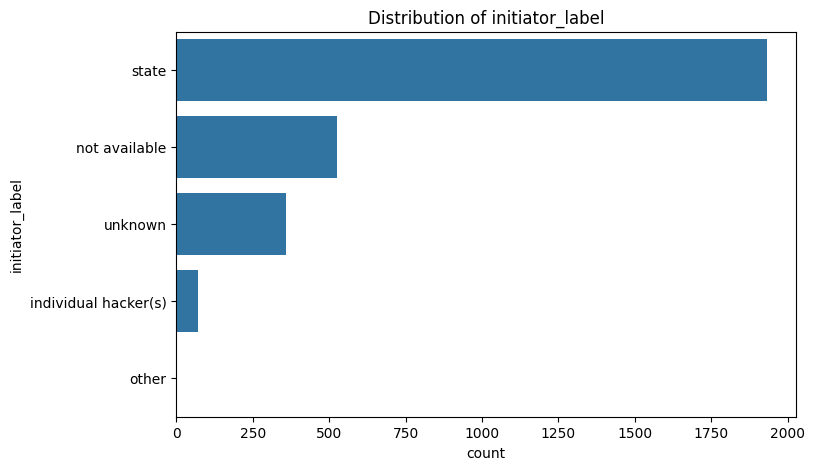

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.countplot(y='initiator_label', data=df, order=df['initiator_label'].value_counts().index)
plt.title("Distribution of initiator_label")
plt.show()

Multivariate: incidents per year by initiator type

Using target column: initiator_category


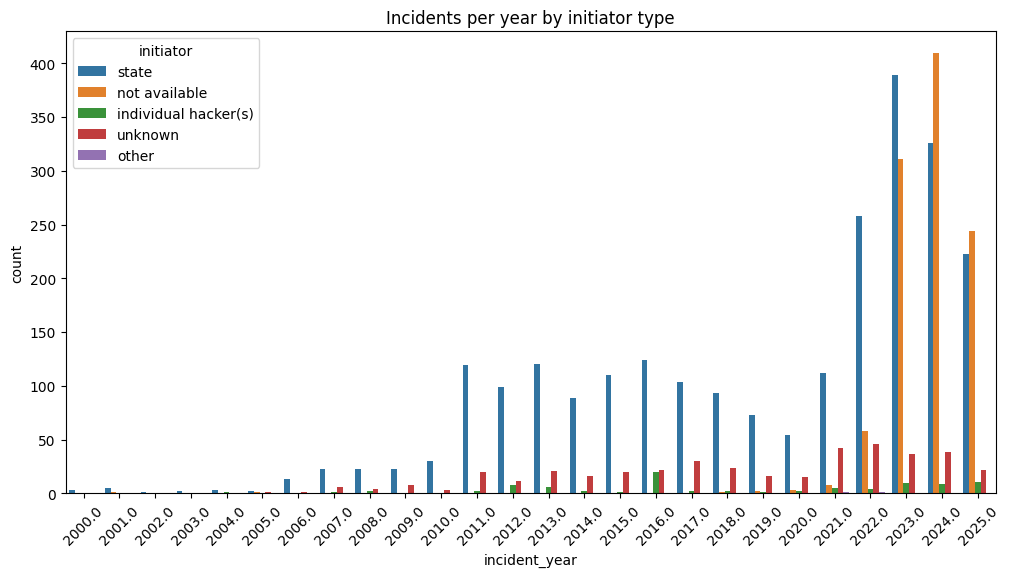

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df['start_date'] = pd.to_datetime(df['start_date'], errors='coerce')
df['incident_year'] = df['start_date'].dt.year

# Create initiator_label column (copied from cell jS4levQEE9YW)
candidate = [c for c in df.columns if 'initiator' in c.lower() or 'attribution' in c.lower()]
target_col = None
for c in candidate:
    if 'category' in c.lower() or 'type' in c.lower():
        target_col = c
        break
if target_col is None and candidate:
    target_col = candidate[0]

print("Using target column:", target_col)

def simplify_target(x):
    if pd.isna(x): return 'unknown'
    s = str(x).lower()
    if ';' in s: s = s.split(';')[0]
    if 'state' in s or 'government' in s: return 'state'
    if 'criminal' in s or 'crime' in s: return 'criminal'
    if 'activist' in s or 'hacktivist' in s: return 'activist'
    if 'unknown' in s or s.strip()=='' : return 'unknown'
    return s

if target_col:
    df['initiator_label'] = df[target_col].apply(simplify_target)
else:
    df['initiator_label'] = 'unknown'

# Create tmp dataframe *after* initiator_label is created
tmp = df.dropna(subset=['incident_year'])

plt.figure(figsize=(12,6))
sns.countplot(x='incident_year', hue='initiator_label', data=tmp)
plt.xticks(rotation=45)
plt.title("Incidents per year by initiator type")
plt.legend(title='initiator')
plt.show()

Another multivariate: operation type vs initiator

In [10]:
col_op = 'operation_type' if 'operation_type' in df.columns else None
if col_op:
    plt.figure(figsize=(10,6))
    top_ops = df[col_op].value_counts().nlargest(15).index
    sns.countplot(y=col_op, hue='initiator_label', data=df[df[col_op].isin(top_ops)])
    plt.title(f"{col_op} vs initiator_label (top {len(top_ops)})")
    plt.show()
else:
    print("No operation_type column found; rename if needed.")

No operation_type column found; rename if needed.


**Prepare data for modeling (encode, split, train)**

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Select useful categorical features
candidate_feats = []
for name in ['operation_type','incident_type','victim_sector','initiator_country','receiver_country','target_type']:
    if name in df.columns:
        candidate_feats.append(name)
if not candidate_feats:
    candidate_feats = [c for c in df.columns if df[c].dtype=='object'][:5]

print("Selected features:", candidate_feats)

model_df = df[df['initiator_label'] != 'unknown'].copy()
X = model_df[candidate_feats].fillna('missing').astype(str)
y = model_df['initiator_label']

# Get counts of each class in y
class_counts = y.value_counts()
# Identify classes with only one member
single_member_classes = class_counts[class_counts < 2].index
# Filter out rows where y belongs to single_member_classes
model_df = model_df[~model_df['initiator_label'].isin(single_member_classes)].copy()

X = model_df[candidate_feats].fillna('missing').astype(str)
y = model_df['initiator_label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

pre = ColumnTransformer([('cat', OneHotEncoder(handle_unknown='ignore'), X.columns.tolist())])

pipe_rf = Pipeline([('pre', pre),
                    ('clf', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42))])

pipe_lr = Pipeline([('pre', pre),
                    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))])

print("Training Random Forest...")
pipe_rf.fit(X_train, y_train)
pred_rf = pipe_rf.predict(X_test)
print("RF accuracy:", accuracy_score(y_test, pred_rf))
print(classification_report(y_test, pred_rf))

print("Training Logistic Regression...")
pipe_lr.fit(X_train, y_train)
pred_lr = pipe_lr.predict(X_test)
print("LR accuracy:", accuracy_score(y_test, pred_lr))
print(classification_report(y_test, pred_lr))

Selected features: ['incident_type', 'initiator_country', 'receiver_country']
Training Random Forest...
RF accuracy: 0.8767772511848341
                      precision    recall  f1-score   support

individual hacker(s)       0.17      0.11      0.13        18
       not available       0.73      0.92      0.81       132
               state       0.95      0.89      0.92       483

            accuracy                           0.88       633
           macro avg       0.62      0.64      0.62       633
        weighted avg       0.88      0.88      0.88       633

Training Logistic Regression...
LR accuracy: 0.8072669826224329
                      precision    recall  f1-score   support

individual hacker(s)       0.12      0.39      0.18        18
       not available       0.70      0.95      0.81       132
               state       0.96      0.78      0.86       483

            accuracy                           0.81       633
           macro avg       0.59      0.71      0.62

**Show top features (Random Forest importance)**

In [16]:
ohe = pipe_rf.named_steps['pre'].named_transformers_['cat']
feat_names = ohe.get_feature_names_out(X.columns.tolist())
importances = pipe_rf.named_steps['clf'].feature_importances_
imp_series = pd.Series(importances, index=feat_names).sort_values(ascending=False).head(30)
print(imp_series)

initiator_country_Not available                                         0.230835
initiator_country_Unknown                                               0.057641
incident_type_Data theft & Doxing                                       0.056259
initiator_country_Russia                                                0.029149
receiver_country_United States                                          0.025313
incident_type_Disruption                                                0.024053
initiator_country_China                                                 0.019540
incident_type_Data theft; Hijacking with Misuse                         0.017727
receiver_country_Spain                                                  0.017350
initiator_country_United States                                         0.016261
initiator_country_Pakistan                                              0.013760
incident_type_Disruption; Hijacking with Misuse                         0.013691
receiver_country_Spain; Spai

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import pandas as pd

#  Evaluate Model 1: Random Forest
print(" Random Forest Evaluation:")
pred_rf = pipe_rf.predict(X_test)
print(classification_report(y_test, pred_rf))

#  Evaluate Model 2: Logistic Regression
print("\n Logistic Regression Evaluation:")
pred_lr = pipe_lr.predict(X_test)
print(classification_report(y_test, pred_lr))

#  Compare Results in a Table
results = {
    "Model": ["Random Forest", "Logistic Regression"],
    "Accuracy": [
        accuracy_score(y_test, pred_rf),
        accuracy_score(y_test, pred_lr)
    ],
    "Precision": [
        precision_score(y_test, pred_rf, average='macro'),
        precision_score(y_test, pred_lr, average='macro')
    ],
    "Recall": [
        recall_score(y_test, pred_rf, average='macro'),
        recall_score(y_test, pred_lr, average='macro')
    ],
    "F1-score": [
        f1_score(y_test, pred_rf, average='macro'),
        f1_score(y_test, pred_lr, average='macro')
    ]
}

comparison_df = pd.DataFrame(results)
print(comparison_df)

 Random Forest Evaluation:
                      precision    recall  f1-score   support

individual hacker(s)       0.17      0.11      0.13        18
       not available       0.73      0.92      0.81       132
               state       0.95      0.89      0.92       483

            accuracy                           0.88       633
           macro avg       0.62      0.64      0.62       633
        weighted avg       0.88      0.88      0.88       633


 Logistic Regression Evaluation:
                      precision    recall  f1-score   support

individual hacker(s)       0.12      0.39      0.18        18
       not available       0.70      0.95      0.81       132
               state       0.96      0.78      0.86       483

            accuracy                           0.81       633
           macro avg       0.59      0.71      0.62       633
        weighted avg       0.88      0.81      0.83       633

                 Model  Accuracy  Precision    Recall  F1-score
0

Interpretation:

Two classification algorithms — Random Forest and Logistic Regression — were applied to predict the type of cyber attack initiator.

The Random Forest model achieved the highest overall accuracy of 87.7%, with a Precision of 61.5%, Recall of 64.1%, and F1-score of 62.2%. This indicates that the model is strong at correctly predicting the initiator type while maintaining a good balance between correctly identifying positive cases and avoiding false positives.

The Logistic Regression model achieved a slightly lower accuracy of 80.7%, with Precision of 59.2%, Recall of 70.9%, and F1-score of 61.6%. While Logistic Regression has a higher recall, it sacrifices some precision, meaning it catches more actual attacks but also predicts more false positives.

Conclusion:
Based on these results, Random Forest is the preferred model for this dataset due to its higher overall accuracy and balanced performance. Logistic Regression remains valuable for understanding feature effects and maintaining interpretability but is slightly less accurate in predicting the initiator type.